# CV+ : Generating Confidence Intervals for Regression Models 

- Paper can be found here: https://projecteuclid.org/journals/annals-of-statistics/volume-49/issue-1/Predictive-inference-with-the-jackknife/10.1214/20-AOS1965.full
- In this notebook we use Jackknife+ (that's a special category of CV+) 

Import packages 

In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from typing import Dict
import torch
import json
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, log_loss
from scipy.stats import pointbiserialr
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor 
import sklearn.gaussian_process as gp
from scipy.stats import pearsonr
import pickle

Read data 

In [3]:
X_train = np.load('/Users/mariaallayioti/Desktop/cognomotiv/CV+ data/output/X_train_down.npy')
print(len(X_train))
print(X_train.shape)

786
(786, 32)


In [4]:
y_train = np.load('/Users/mariaallayioti/Desktop/cognomotiv/CV+ data/output/Y_train.npy')
len(y_train)

786

In [5]:
X_test = np.load('/Users/mariaallayioti/Desktop/cognomotiv/CV+ data/output/X_test_down.npy')
print(len(X_test))
print(X_test.shape)

394
(394, 32)


In [6]:
y_test = np.load('/Users/mariaallayioti/Desktop/cognomotiv/CV+ data/output/Y_test.npy')
len(y_test)

394

In [7]:
X_infer = np.load('/Users/mariaallayioti/Desktop/cognomotiv/CV+ data/infer/X_down.npy')
X_infer.shape

(1180, 32)

In [8]:
parquet_file_path_1 = '/Users/mariaallayioti/Desktop/cognomotiv/CV+ data/output/train/pred/LinearRegression_pred.parquet'
LR_train_pred = pd.read_parquet(parquet_file_path_1)

parquet_file_path_2 = '/Users/mariaallayioti/Desktop/cognomotiv/CV+ data/output/train/pred/DecisionTreeRegressor_pred.parquet'
DT_train_pred = pd.read_parquet(parquet_file_path_2)

parquet_file_path_3 = '/Users/mariaallayioti/Desktop/cognomotiv/CV+ data/output/train/pred/GaussianProcessRegressor_pred.parquet'
GP_train_pred = pd.read_parquet(parquet_file_path_3)

parquet_file_path_4 = '/Users/mariaallayioti/Desktop/cognomotiv/CV+ data/output/train/pred/GradientBoostingRegressor_pred.parquet'
GB_train_pred = pd.read_parquet(parquet_file_path_4)

parquet_file_path_5 = '/Users/mariaallayioti/Desktop/cognomotiv/CV+ data/output/test/pred/LinearRegression_pred.parquet'
LR_test_pred = pd.read_parquet(parquet_file_path_5)

parquet_file_path_6 = '/Users/mariaallayioti/Desktop/cognomotiv/CV+ data/output/test/pred/DecisionTreeRegressor_pred.parquet'
DT_test_pred = pd.read_parquet(parquet_file_path_6)

parquet_file_path_7 = '/Users/mariaallayioti/Desktop/cognomotiv/CV+ data/output/test/pred/GaussianProcessRegressor_pred.parquet'
GP_test_pred = pd.read_parquet(parquet_file_path_7)

parquet_file_path_8 = '/Users/mariaallayioti/Desktop/cognomotiv/CV+ data/output/test/pred/GradientBoostingRegressor_pred.parquet'
GB_test_pred = pd.read_parquet(parquet_file_path_8)

Create dataframes (to check ids, not used below) 

In [9]:
ID_train = LR_train_pred.id.tolist()
ID_test = LR_test_pred.id.tolist()

In [10]:
X_train_df = pd.DataFrame(X_train, index = ID_train)
X_test_df = pd.DataFrame(X_test, index = ID_test)

In [11]:
X_train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
c481acc59f0f0e698d04e0fe325fa692,0.565611,0.757384,0.858853,0.928508,0.362339,1.026386,0.829142,0.409454,0.291805,0.422199,...,1.150984,0.786143,0.996132,0.634093,0.641087,0.995256,1.198004,0.682721,1.159029,0.245273
a4191724bebe613c66fa499af5634dfe,0.532769,0.699586,0.912806,0.585746,0.406417,0.973662,0.691562,0.344478,0.376626,0.498074,...,1.133332,0.801222,0.926708,0.656522,0.870397,1.005266,1.204890,0.669139,1.138568,0.360737
6d4d6ccf414e5f4cf819ee78063a2602,0.613626,0.869569,0.881032,1.183805,0.571007,0.986950,1.162453,0.871060,0.283986,0.759909,...,0.847948,0.797715,1.269641,0.979631,0.787883,0.684844,1.120300,0.743933,0.897906,0.789778
39658674a6b51c105bd2598a0e0f7382,0.536421,0.909928,0.943332,0.045565,0.484423,0.915467,0.288440,0.410115,0.418913,0.734451,...,0.999188,0.770594,0.116019,0.781434,0.948525,0.736040,1.179656,0.436505,0.834596,0.401228
f6d605428adebc218b63a6e1e8c03b55,0.536299,0.890219,0.933273,-0.005956,0.459916,0.890739,0.200492,0.406411,0.432546,0.712370,...,0.932055,0.769993,0.085408,0.787078,0.954107,0.813751,1.189179,0.391057,0.827726,0.465548


In [12]:
X_train_df.to_pickle('X_train_rul.pkl')

In [13]:
X_test_df.to_pickle('X_test_rul.pkl')

In [29]:
y_train_list = np.array(LR_train_pred['prediction'])
y_test_list = np.array(LR_test_pred['prediction'])

In [30]:
with open('y_train_rul.pkl', 'wb') as file:
    pickle.dump(y_train_list, file)
with open('y_test_rul.pkl', 'wb') as file:
    pickle.dump(y_test_list, file)

Jackknife+

In [879]:
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))

model_1 = DecisionTreeRegressor(min_samples_leaf=5, random_state = 0)
model_2 = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.2, normalize_y=True, random_state = 0)
model_3 = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=2, random_state=0,loss='squared_error')

In [880]:
# K-fold CV (LOO)
# Get K predictions for each X_test instance (one for each of the K models fitted in K-fold CV)
# Calculate the residuals for each X_train instance (using the model for which the instance was unseen)
# Get K predictions for each instance in X_infer

def CV_plus(test_data, CIM_model):
    kf = KFold(n_splits=len(y_train), shuffle=True, random_state=42)
    res = []
    arrays = []
    estimators = []

    for train_index, test_index in kf.split(X_train):
        X_train_, X_test_ = X_train[train_index], X_train[test_index]
        y_train_, y_test_ = y_train[train_index], y_train[test_index]
        print(y_test_)
        model = CIM_model
        model.fit(X_train_, y_train_)
        test_preds = model.predict(test_data)
        arr = np.array(test_preds).reshape(-1, 1)
        arrays.append(arr)
        res.extend(list(y_test_ - model.predict(X_test_)))
    
    y_pred_multi = np.hstack(arrays)
    res  = [abs(x) for x in res]
    
    return y_pred_multi, res

In [881]:
print(y_pred_multi_test.shape)
print(y_pred_multi_infer.shape)

(394, 786)
(1180, 786)


In [882]:
# Find the lower and upper bounds of the CI

def CI_bounds(alpha, preds, res):
    top = []
    bottom = []
    for i in range(preds.shape[0]):
        top.append(np.quantile(preds[i] + res, 1 - alpha))
        bottom.append(np.quantile(preds[i] - res, alpha))
    return bottom, top
        
alpha = 0.20

In [883]:
[bottom_test, top_test] = CI_bounds(alpha, y_pred_multi_test, res_test)
[bottom_infer, top_infer] = CI_bounds(alpha, y_pred_multi_infer, res_infer)

In [824]:
len(top_test)

394

In [884]:
# Create a dataframe the the median prediction of each inference set's instance and CI
# Add columns for width of CI, normalized width, and the new chase factor 

def CI_dataframe(bottom, top, y_pred):
    preds = []
    for i in range(y_pred.shape[0]):
        preds.append(np.median(y_pred[i]))
    df = pd.DataFrame()
    df['lower'] = bottom
    df['pred'] = preds
    df['upper'] = top
    df['width'] = df['upper'] - df['lower']
    scaler = MinMaxScaler()
    df['norm_width'] = scaler.fit_transform(df[['width']])
    #df['norm_width'] = df['width'] / df['width'].max()
    df['chase_width'] = 1 - df['norm_width']
    return df

In [885]:
test_CI_df = CI_dataframe(bottom_test, top_test, y_pred_multi_test)
infer_CI_df = CI_dataframe(bottom_infer, top_infer, y_pred_multi_infer)

/Users/mariaallayioti/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/mariaallayioti/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/mariaallayioti/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/mariaallayioti/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in 

In [886]:
test_CI_df

,lower,pred,upper,width,norm_width,chase_width
0,-77.556667,287.183333,656.240000,733.796667,0.071186,0.928814
1,-160.456667,204.283333,573.263333,733.720000,0.070843,0.929157
2,531.115000,928.640000,1282.623333,751.508333,0.150423,0.849577
3,-275.777143,87.542857,452.282857,728.060000,0.045522,0.954478
4,574.985000,976.757143,1322.517143,747.532143,0.132635,0.867365
...,...,...,...,...,...,...
389,-180.040000,184.700000,549.440000,729.480000,0.051875,0.948125
390,-234.040000,132.820000,497.560000,731.600000,0.061359,0.938641
391,1001.166667,1413.500000,1732.477778,731.311111,0.060067,0.939933
392,300.800000,625.720000,1036.142222,735.342222,0.078101,0.921899


        lower        pred        upper       width  norm_width  chase_width
0  -77.556667  287.183333   656.240000  733.796667    0.071186     0.928814
1 -160.456667  204.283333   573.263333  733.720000    0.070843     0.929157
2  531.115000  928.640000  1282.623333  751.508333    0.150423     0.849577
3 -275.777143   87.542857   452.282857  728.060000    0.045522     0.954478
4  574.985000  976.757143  1322.517143  747.532143    0.132635     0.867365


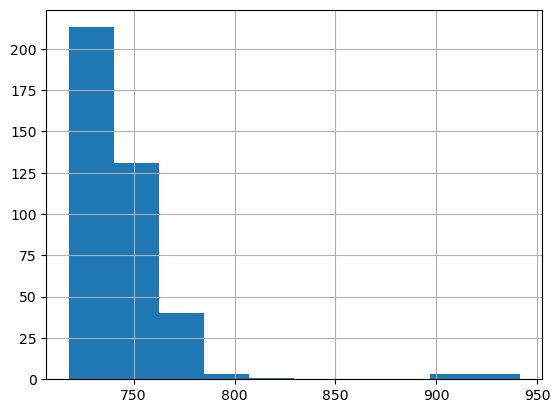

In [887]:
print(test_CI_df.head())
test_CI_df.width.hist();

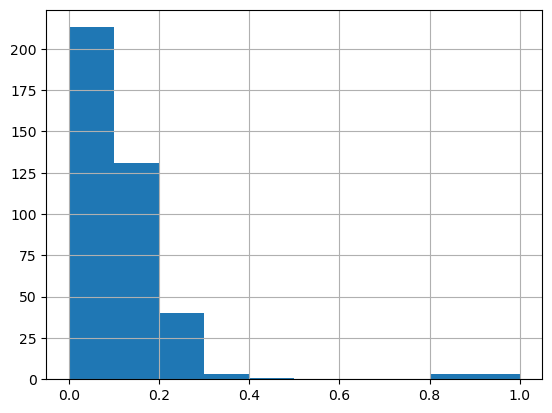

In [888]:
test_CI_df.norm_width.hist();

         lower         pred        upper       width  norm_width  chase_width
0  1104.427500  1502.587500  1867.327500  762.900000    0.670516     0.329484
1   -17.220000   346.100000   728.980000  746.200000    0.349115     0.650885
2  1104.427500  1502.587500  1869.447500  765.020000    0.711316     0.288684
3  1234.143333  1642.383333  1986.423333  752.280000    0.466128     0.533872
4  1124.404167  1502.587500  1869.851429  745.447262    0.334628     0.665372


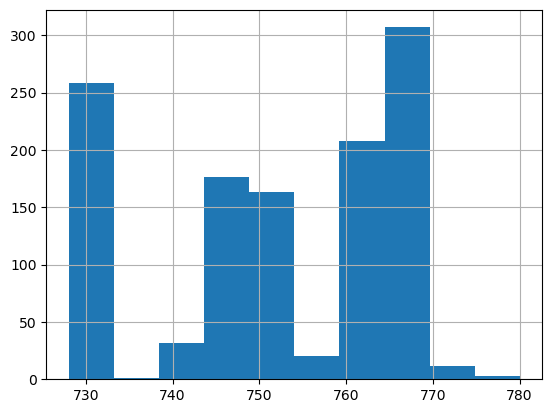

In [889]:
print(infer_CI_df.head())
infer_CI_df.width.hist();

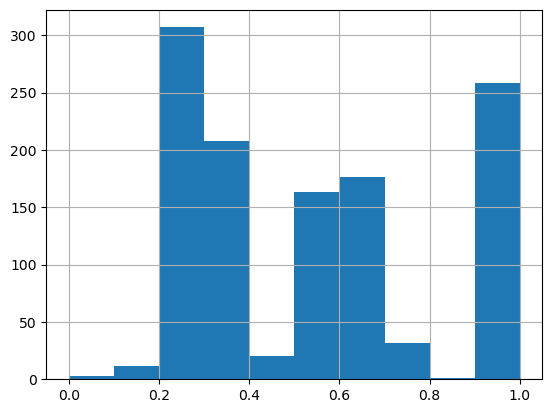

In [890]:
infer_CI_df.chase_width.hist();

Assurance scores

- Inference results dataframe (CIM output) with added column for chase width

In [833]:
parquet_file_infer = '/Users/mariaallayioti/Desktop/cognomotiv/CV+/infer/DecisionTreeRegressor_pred.parquet'
#parquet_file_infer = '/Users/mariaallayioti/Desktop/cognomotiv/CV+/infer/GaussianProcessRegressor_pred.parquet'

infer_results = pd.read_parquet(parquet_file_infer)
infer_results['chase_width'] = infer_CI_df['chase_width']
infer_results.head()

,id,prediction,mae,r_square,pred_clf,pred_f1,pred_prec,pred_recall,pred_clf_chase,nearest_cls,cls_error,error_norm,cert,has_labels,output_confidence,chase_width
0,000d12d90e60dffc0882ff778c39552f,1533.040000,249.04244,0.278313,1,0.664311,0.587500,0.764228,51,51,696.866667,0.381845,0.618155,False,,0.194055
1,003b5ecb4894f10800533d739efef579,270.755556,249.04244,0.278313,0,0.811881,0.876068,0.756458,9,9,251.868762,0.138010,0.861990,False,,0.341422
2,00529bea3c2a1004fa830ba4c091c0bf,1533.040000,249.04244,0.278313,1,0.664311,0.587500,0.764228,51,51,696.866667,0.381845,0.618155,False,,0.079334
3,00adb45c9b76590eee9a1f6457e750a1,732.400000,249.04244,0.278313,1,0.664311,0.587500,0.764228,24,23,277.510000,0.152060,0.847940,False,,0.342388
4,00e6352e39107e028b62aab5c3c70fe8,518.966667,249.04244,0.278313,1,0.664311,0.587500,0.764228,17,17,368.716944,0.202037,0.797963,False,,0.210763


- New dataframe that includes the ground truth for inference dataset (column 'lifetime')

In [834]:
infer_raw_csv = '/Users/mariaallayioti/Desktop/cognomotiv/CV+/infer/Aging_DCGAN_NoAging_NormalOnly_10000_ETL_WIN200_2.csv'
infer_raw = pd.read_csv(infer_raw_csv)
true_label = infer_raw[['id','lifetime']].drop_duplicates()
chase_true = pd.merge(infer_results, true_label, on = 'id', how = 'inner')
print(chase_true.shape)
chase_true.head()

(1180, 17)


,id,prediction,mae,r_square,pred_clf,pred_f1,pred_prec,pred_recall,pred_clf_chase,nearest_cls,cls_error,error_norm,cert,has_labels,output_confidence,chase_width,lifetime
0,000d12d90e60dffc0882ff778c39552f,1533.040000,249.04244,0.278313,1,0.664311,0.587500,0.764228,51,51,696.866667,0.381845,0.618155,False,,0.194055,1539.7
1,003b5ecb4894f10800533d739efef579,270.755556,249.04244,0.278313,0,0.811881,0.876068,0.756458,9,9,251.868762,0.138010,0.861990,False,,0.341422,616.8
2,00529bea3c2a1004fa830ba4c091c0bf,1533.040000,249.04244,0.278313,1,0.664311,0.587500,0.764228,51,51,696.866667,0.381845,0.618155,False,,0.079334,870.2
3,00adb45c9b76590eee9a1f6457e750a1,732.400000,249.04244,0.278313,1,0.664311,0.587500,0.764228,24,23,277.510000,0.152060,0.847940,False,,0.342388,334.6
4,00e6352e39107e028b62aab5c3c70fe8,518.966667,249.04244,0.278313,1,0.664311,0.587500,0.764228,17,17,368.716944,0.202037,0.797963,False,,0.210763,16.5


- Test results dataframe with added column for chase width

In [891]:
DT_test_pred['chase_width'] = test_CI_df['chase_width']
DT_test_pred.head()

,id,prediction,y_true,abs_error,mae,r_square,true_clf,pred_clf,true_clf_chase,chase_width
0,ef2cafcf89930de7582b85fbc2317a24,287.183333,320.4,33.216667,213.800769,0.333438,0,0,10,0.928814
1,60bd4034b11e497b282193140494d6fb,204.283333,239.7,35.416667,213.800769,0.333438,0,0,7,0.929157
2,ee9b13417fe6028c20e8503602b9641d,928.640000,314.9,613.740000,213.800769,0.333438,0,1,10,0.849577
3,acb56c76fd284576a3e459d4c5fcb0ec,87.542857,97.1,9.557143,213.800769,0.333438,0,0,3,0.954478
4,b46d6b20c8574739406dd99a66b1a9da,976.757143,897.8,78.957143,213.800769,0.333438,1,1,29,0.867365


- Assurance score calculation

In [893]:
# Code from calc_tsr_assurance_score function at https://github.com/Cognomotiv/pycimtools/blob/main/src/pycimtools/chase/reg.py

def weighted_average(x, w):

    assert len(x) == len(w)
    numerator = sum([x[i] * w[i] for i in range(len(x))])
    denominator = sum(w)
    return numerator / denominator


def calc_tsr_assurance_score(row, mae_scale):
    std = [idx for idx, name in enumerate(row.index) if 'std' in name]
    #cert = [idx for idx, name in enumerate(row.index) if 'cert' in name]
    r_square = [idx for idx, name in enumerate(row.index) if 'r_square' in name][0]
    mae = [idx for idx, name in enumerate(row.index) if 'mae' in name][0]

    factors = []
    if len(std) > 0:
        factors.append(max(0, 1 - row.iloc[std[0]]))
    #if len(cert) > 0:
        #factors.append(row.iloc[cert[0]])
    factors.extend([row.iloc[r_square], 1 - row.iloc[mae] / mae_scale])

    weights = [1] * len(factors)
    assurance = weighted_average(factors, weights)

    return round(assurance, 4)

def calc_tsr_assurance_score_new(row, mae_scale):
    std = [idx for idx, name in enumerate(row.index) if 'std' in name]
    chase_width = [idx for idx, name in enumerate(row.index) if 'chase_width' in name]
    r_square = [idx for idx, name in enumerate(row.index) if 'r_square' in name][0]
    mae = [idx for idx, name in enumerate(row.index) if 'mae' in name][0]
    chase_width = [idx for idx, name in enumerate(row.index) if 'chase_width' in name]

    factors = []
    if len(std) > 0:
        factors.append(max(0, 1 - row.iloc[std[0]]))
    if len(chase_width) > 0:
        factors.append(row.iloc[chase_width[0]])
    factors.extend([row.iloc[r_square], 1 - row.iloc[mae] / mae_scale])

    weights = [1] * len(factors)
    assurance = weighted_average(factors, weights)

    return round(assurance, 4)

def assurance_score_calc(df):
    assurance_scores_initial = []
    assurance_scores_new = []
    for index, row in df.iterrows():
        assurance_scores_initial.append(calc_tsr_assurance_score(row, mae_scale))
        assurance_scores_new.append(calc_tsr_assurance_score_new(row, mae_scale))
    return assurance_scores_initial, assurance_scores_new

In [894]:
mae_scale = 365*5  # maximum can be 5 years 
#[test_scores_initial, test_scores_new]  = assurance_score_calc(DT_test_pred)
#[infer_scores_initial, infer_scores_new] = assurance_score_calc(chase_true)

[test_scores_initial, test_scores_new]  = assurance_score_calc(DT_test_pred)
[infer_scores_initial, infer_scores_new] = assurance_score_calc(chase_true)

CHASE evaluation

- Infer set

In [838]:
#If the difference between predicted value and ground truth is >50 then prediction is wrong

chase_eval_infer = pd.DataFrame()
chase_eval_infer['true_labels'] = abs(chase_true.prediction - chase_true.lifetime)<50
chase_eval_infer['chase_initial'] = pd.Series(infer_scores_initial)>0.5
chase_eval_infer['chase_cv'] = pd.Series(infer_scores_new)>0.5

In [839]:
chase_eval_infer.true_labels.value_counts()

true_labels
False    1102
True       78
Name: count, dtype: int64

In [840]:
chase_eval_infer.chase_cv.value_counts()

chase_cv
False    778
True     402
Name: count, dtype: int64

In [841]:
chase_eval_infer.chase_initial.value_counts()

chase_initial
True    1180
Name: count, dtype: int64

- Test set

In [946]:
chase_eval_test = pd.DataFrame()
chase_eval_test['true_labels'] = abs(DT_test_pred.prediction - DT_test_pred.y_true)<50
#chase_eval_test['true_labels'] = abs(GP_test_pred.prediction - GP_test_pred.y_true)<50
chase_eval_test['chase_initial'] = pd.Series(test_scores_initial)>0.5
chase_eval_test['chase_cv'] = pd.Series(test_scores_new)>0.5

In [947]:
chase_eval_test.true_labels.value_counts()

true_labels
False    276
True     118
Name: count, dtype: int64

In [948]:
chase_eval_test.chase_initial.value_counts()

chase_initial
True    394
Name: count, dtype: int64

In [949]:
chase_eval_test.chase_cv.value_counts()

chase_cv
True     388
False      6
Name: count, dtype: int64

In [901]:
# Evaluate chase (function from https://github.com/Cognomotiv/pycimtools/blob/main/src/pycimtools/chase/eval.py)

def calc_assurance_eval_clf(true_acc, pred_acc,assurance):
    
    '''Computes some evaluation metrics for an assurance-based 'meta-classifier'

    Parameters
    ----------
    true_acc: numpy array or list of integers
        an array of binary accuracies (for a CIM)
    pred_acc:
        an array of binary "predicted accuracies" (thresholded assurance scores)
    assurance: numpy array or list of floats
        an array of assurance scores (between 0 and 1)

    Returns
    -------
    f1, auc, pbsr, logloss: tuple of floats
        a tuple of F1, ROC-AUC, Point-biserial correlation, and Log-Loss scores.
    '''
    
    f1 = f1_score(true_acc, pred_acc)
    auc = roc_auc_score(true_acc, assurance)
    #pbsr = pointbiserialr(true_acc, assurance).correlation
    logloss = log_loss(true_acc, assurance)
    return f1, auc, logloss

- Test

In [950]:
[f1_init, auc_init, logloss_init]= calc_assurance_eval_clf(chase_eval_test.true_labels, chase_eval_test.chase_initial, test_scores_initial)
[f1_cv, auc_cv, logloss_cv]= calc_assurance_eval_clf(chase_eval_test.true_labels, chase_eval_test.chase_cv, test_scores_new)

In [951]:
columns = ['f1', 'auc', 'logloss']
chase_eval_df = pd.DataFrame(columns = columns)

In [952]:
chase_eval_df.loc['Initial'] = [f1_init, auc_init, logloss_init]
chase_eval_df.loc['New'] = [f1_cv, auc_cv, logloss_cv]

In [953]:
chase_eval_df

,f1,auc,logloss
Initial,0.460938,0.50000,0.805172
New,0.466403,0.59755,0.938644


- Infer

In [860]:
[f1_init, auc_init, logloss_init]= calc_assurance_eval_clf(chase_eval_infer.true_labels, chase_eval_infer.chase_initial, infer_scores_initial)
[f1_cv, auc_cv, logloss_cv]= calc_assurance_eval_clf(chase_eval_infer.true_labels, chase_eval_infer.chase_cv, infer_scores_new)

In [861]:
columns = ['f1', 'auc', 'logloss']
chase_eval_df = pd.DataFrame(columns = columns)

In [862]:
chase_eval_df.loc['Initial'] = [f1_init, auc_init, logloss_init]
chase_eval_df.loc['New'] = [f1_cv, auc_cv, logloss_cv]

In [863]:
chase_eval_df

,f1,auc,logloss
Initial,0.124006,0.500000,0.827192
New,0.175000,0.625494,0.718003


Conclusions:

- The confidence intervals are very wide and that provides the information that the model does not do a good job on predicting the remaining battery life of unseen data. This conclusion agrees with what we knew so far.
- Adding the width of the confidence intervals as a factor in assurance score has a small improvement in some KPIs when evaluating CHASE.
- We observe that in tis case the distribution of the widths is concentrated around a particular interval of values and there is not much variability. In cases with more variability we expect more improvement in the KPIs. Consider different scaling method
- This method might be slow because we are training a model multiple times 
- The confidence intervals can be provided along with assurance scores 